In [67]:
import numpy as np
import torch
import os
import cv2
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet34
from google.colab import auth
from googleapiclient.discovery import build
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

In [68]:
def download_data(file_id, file_name):
  import io
  from googleapiclient.http import MediaIoBaseDownload

  request = drive_service.files().get_media(fileId=file_id)
  downloaded = io.BytesIO()
  downloader = MediaIoBaseDownload(downloaded, request)
  done = False
  while done is False:
    _, done = downloader.next_chunk()
    
  downloaded.seek(0)
  with open(file_name, "wb") as f:
    f.write(downloaded.read())

  
auth.authenticate_user()
drive_service = build('drive', 'v3')

file_id = '139wA_Z9kustXy54ifhWWHJvARo5f7O6y'
file_name = 'star_wars.tar.gz'

download_data(file_id, file_name)
!tar xf star_wars.tar.gz

In [69]:
filenames = []
labels = []
for idx, class_dir in enumerate(os.listdir("star_wars")):
  print(f"берем файлы из папки \"{class_dir}\" и даем им класс {idx}")
  
  # не берем файлы кроме .jpg .jpeg и .png
  for file in os.listdir(os.path.join("star_wars", class_dir)):
    if not file.endswith(('.jpg', '.jpeg', '.png')):
      continue
      
    filenames.append(os.path.join("star_wars", class_dir, file))
    labels.append(idx)

берем файлы из папки "чубакка" и даем им класс 0
берем файлы из папки "принцесса лея" и даем им класс 1
берем файлы из папки "дарт вейдер" и даем им класс 2
берем файлы из папки "люк скайуокер" и даем им класс 3


0


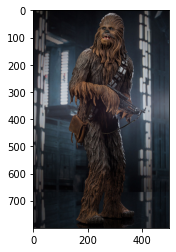

In [70]:
# будем брать по 1 рандомной картинке, выводить ее и смотреть на класс. Так в реально жизни можно проверить не *** ли вы скачали и верные ли классы
# можете выполнять этот cell пока не надоест
random_index = np.random.choice(range(len(filenames)))
test_img = cv2.imread(filenames[random_index])[:, :, ::-1] # эта штука в конце равносильно переводу из BGR в RGB
print(labels[random_index])
plt.imshow(test_img)

In [71]:
# Задание 1. Разбейте filenames и labels на train и test части 70/30
train_filenames, test_filenames, train_labels, test_labels = train_test_split(filenames, labels, test_size=0.30)

In [72]:
def add_pad(img, shape):
    color_pick = img[0][0]
    padded_img = color_pick * np.ones(shape + img.shape[2:3], dtype=np.uint8)
    x_offset = int((padded_img.shape[0] - img.shape[0]) / 2)
    y_offset = int((padded_img.shape[1] - img.shape[1]) / 2)
    padded_img[x_offset:x_offset + img.shape[0], y_offset:y_offset + img.shape[1]] = img

    return padded_img


def resize(img, shape):
    scale = min(shape[0] * 1.0 / img.shape[0], shape[1] * 1.0 / img.shape[1])
    if scale != 1:
        img = cv2.resize(img, dsize=None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
    return img

In [73]:
# Задание 2. Реализуйте класс-наследник Dataset. Он должен возвращать по индексу 
class StarWarsDataset(Dataset):
    def __init__(self, filenames, labels):
        self._filenames = filenames
        self._labels = labels

    def __len__(self):
        return len(self._filenames)

    def __getitem__(self, idx):
        # dataloader запросит какой-то индекс (но не больше чем значение __len__)
        # мы должны отдать ему image в виде массива и соотвуствующий ему label
        filename = self._filenames[idx]
        label = self._labels[idx]
        
        # мы получили имя файла, теперь нужно загрузить картинку как numpy array 
        # и изменить размер так, чтобы он был 224 на 224
        img = np.array(cv2.imread(filename)[:, :, ::-1])
        
        img_standat_size = (224, 224)
        img = resize(img, img_standat_size)
        img = add_pad(img, img_standat_size)
      
        
        # меняем порядок каналов и делим все на 255, оборачиваем в torch tensor
        # это просто надо делать, потом спросите зачем
        img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1) / 255.
        return img, label

In [74]:
train_dataset = StarWarsDataset(train_filenames, train_labels)
train_dataloder = DataLoader(train_dataset, shuffle=True, batch_size=64, num_workers=0)

In [75]:
# Задание 3. Сделайте dataloader для test
test_dataset = StarWarsDataset(test_filenames, test_labels)
test_dataloder = DataLoader(test_dataset, shuffle=True, batch_size=64, num_workers=0)

In [76]:
for batch in test_dataloder: # получаем 1 batch - 1 итерация подгрузки данных
  images, labels = batch     # наш Dataset возвращает tuple, поэтому мы можем сделать так
  print(f'Всего батчей по batch_size: {len(train_dataloder)}')
  print(f'Лейбл первого элемента в первом батче: {labels[0]}')
  print(f'Размер картинки в первом батче: {images[0].shape}')
  print(f'Картинка в первом батче: {images[0]}')
  break

Всего батчей по batch_size: 4
Лейбл первого элемента в первом батче: 2
Размер картинки в первом батче: torch.Size([3, 224, 224])
Картинка в первом батче: tensor([[[0.9882, 0.9882, 0.9882,  ..., 0.9882, 0.9882, 0.9882],
         [0.9882, 0.9882, 0.9882,  ..., 0.9882, 0.9882, 0.9882],
         [0.9882, 0.9882, 0.9882,  ..., 0.9882, 0.9882, 0.9882],
         ...,
         [0.9882, 0.9882, 0.9882,  ..., 0.9882, 0.9882, 0.9882],
         [0.9882, 0.9882, 0.9882,  ..., 0.9882, 0.9882, 0.9882],
         [0.9882, 0.9882, 0.9882,  ..., 0.9882, 0.9882, 0.9882]],

        [[0.9882, 0.9882, 0.9882,  ..., 0.9882, 0.9882, 0.9882],
         [0.9882, 0.9882, 0.9882,  ..., 0.9882, 0.9882, 0.9882],
         [0.9882, 0.9882, 0.9882,  ..., 0.9882, 0.9882, 0.9882],
         ...,
         [0.9882, 0.9882, 0.9882,  ..., 0.9882, 0.9882, 0.9882],
         [0.9882, 0.9882, 0.9882,  ..., 0.9882, 0.9882, 0.9882],
         [0.9882, 0.9882, 0.9882,  ..., 0.9882, 0.9882, 0.9882]],

        [[0.9882, 0.9882, 0.9882, 

In [77]:
# Здесь мы берем предобученный resnet34 и заменяем в нём последний слой на голову классифицирующую изображение на 1 из 4 классов
# Берём кросс энтропию в качестве лосса и оптимизатор адам
# Мы замораживаем все слои сети кроме последнего, который будем обучать далее

model = resnet34(pretrained=True) # resnet обученный на ImageNet
for param in model.parameters():
  param.requires_grad=False

# loss и optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [78]:
# можно принтануть модель и уведеть какие в ней слои
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [79]:
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 4)
model.to('cuda')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [80]:
def run_test_on_epoch(model, epoch, test_loader):
    model.eval()
    with torch.no_grad():
      test_accuracy = []
      test_real = []
      for batch_x, batch_y in test_dataloder:
          outputs = model(batch_x.to('cuda')).detach().cpu().numpy()
          test_accuracy.append(outputs)
          test_real.append(batch_y.detach().cpu().numpy())
    print("Epoch", epoch, "test accuracy", accuracy_score(np.hstack(test_real), np.argmax(np.vstack(test_accuracy), axis=1)))
    model.train()

In [81]:
# Задание 5. Напишите код для обучения модели 25 эпох. В конце каждой эпохи вызывайте run_test_on_epoch() чтобы следить за точностью
for epoch in tqdm(range(25)):
  # что-то очень важное здесь
  # строчек 6 примерно
  for batch_x, batch_y in train_dataloder:
      optimizer.zero_grad()
      preds = model(batch_x.to('cuda'))
      loss_value = criterion(preds, batch_y.to('cuda'))
      loss_value.backward()
      optimizer.step()
  
  
  # половину сделал за вас
  run_test_on_epoch(model, epoch, test_dataloder)














  0%|          | 0/25 [00:00<?, ?it/s]












  4%|▍         | 1/25 [00:06<02:28,  6.17s/it]

Epoch 0 test accuracy 0.21296296296296297















  8%|▊         | 2/25 [00:12<02:20,  6.13s/it]

Epoch 1 test accuracy 0.18518518518518517















 12%|█▏        | 3/25 [00:18<02:14,  6.13s/it]

Epoch 2 test accuracy 0.19444444444444445















 16%|█▌        | 4/25 [00:24<02:09,  6.18s/it]

Epoch 3 test accuracy 0.2037037037037037















 20%|██        | 5/25 [00:30<02:03,  6.19s/it]

Epoch 4 test accuracy 0.2037037037037037















 24%|██▍       | 6/25 [00:36<01:56,  6.16s/it]

Epoch 5 test accuracy 0.2037037037037037















 28%|██▊       | 7/25 [00:43<01:50,  6.14s/it]

Epoch 6 test accuracy 0.18518518518518517















 32%|███▏      | 8/25 [00:49<01:43,  6.10s/it]

Epoch 7 test accuracy 0.18518518518518517















 36%|███▌      | 9/25 [00:55<01:37,  6.11s/it]

Epoch 8 test accuracy 0.18518518518518517















 40%|████      | 10/25 [01:01<01:31,  6.13s/it]

Epoch 9 test accuracy 0.17592592592592593















 44%|████▍     | 11/25 [01:07<01:26,  6.16s/it]

Epoch 10 test accuracy 0.18518518518518517















 48%|████▊     | 12/25 [01:13<01:20,  6.16s/it]

Epoch 11 test accuracy 0.18518518518518517















 52%|█████▏    | 13/25 [01:19<01:13,  6.15s/it]

Epoch 12 test accuracy 0.18518518518518517















 56%|█████▌    | 14/25 [01:26<01:08,  6.19s/it]

Epoch 13 test accuracy 0.18518518518518517















 60%|██████    | 15/25 [01:32<01:01,  6.19s/it]

Epoch 14 test accuracy 0.18518518518518517















 64%|██████▍   | 16/25 [01:38<00:55,  6.18s/it]

Epoch 15 test accuracy 0.18518518518518517















 68%|██████▊   | 17/25 [01:44<00:49,  6.16s/it]

Epoch 16 test accuracy 0.18518518518518517















 72%|███████▏  | 18/25 [01:50<00:43,  6.15s/it]

Epoch 17 test accuracy 0.17592592592592593















 76%|███████▌  | 19/25 [01:56<00:36,  6.14s/it]

Epoch 18 test accuracy 0.18518518518518517















 80%|████████  | 20/25 [02:03<00:30,  6.16s/it]

Epoch 19 test accuracy 0.17592592592592593















 84%|████████▍ | 21/25 [02:09<00:24,  6.19s/it]

Epoch 20 test accuracy 0.17592592592592593















 88%|████████▊ | 22/25 [02:15<00:18,  6.18s/it]

Epoch 21 test accuracy 0.17592592592592593















 92%|█████████▏| 23/25 [02:21<00:12,  6.20s/it]

Epoch 22 test accuracy 0.17592592592592593















 96%|█████████▌| 24/25 [02:27<00:06,  6.20s/it]

Epoch 23 test accuracy 0.17592592592592593















100%|██████████| 25/25 [02:34<00:00,  6.16s/it]

Epoch 24 test accuracy 0.17592592592592593


In [83]:
for batch_x, batch_y in train_dataloder:
    preds = model(batch_x.to('cuda'))
    print(preds[0])
    print(batch_y.to('cuda')[0])

tensor([ 0.7114, -1.2070, -1.4695, -0.8750], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor(2, device='cuda:0')
tensor([ 0.9961, -1.0584, -0.9421, -0.3857], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor(1, device='cuda:0')
tensor([ 0.4932, -0.8420, -1.0806, -0.6436], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor(1, device='cuda:0')
tensor([ 0.3014, -0.9223, -0.9328, -0.6344], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor(0, device='cuda:0')
